In [1]:
def CIFAR_Dynamic_Exp(Num_Tasks,Num_Epochs):
    %matplotlib notebook
    import cntk
    cntk.device.try_set_default_device(cntk.device.gpu(0))
    import os
    os.environ['KERAS_BACKEND'] = 'cntk'
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D, MaxPool2D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz
    import seaborn as sns

    from keras.layers.core import Lambda
    from keras import backend as K    
    
    print(K.cntk_backend.dev.use_default_device())

    def mini_batches(InputSample,BatchSize):
        Index = np.array(range(InputSample.shape[0]),dtype=int)
        NumBatches = np.int(InputSample.shape[0]/BatchSize)
        Removed = np.array([],dtype=int)

        BatchInd =[]
        for BatchLoop in range(NumBatches):
            RemainIndex = np.delete(Index,Removed)
            SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
            Removed = np.append(Removed,SampleInd,axis=0)

            BatchInd.append(SampleInd)
        RemainIndex = np.delete(Index,Removed)
        BatchInd.append(RemainIndex)

        return BatchInd,NumBatches

    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def one_hot(label_list):
        NumLabels = len(label_list)
        MaxLabel = max(label_list)
        one_hot_labels = np.zeros([NumLabels,MaxLabel+1],dtype=int)
        for i in range(NumLabels):
            one_hot_labels[i,label_list[i]-1] = 1

        return one_hot_labels

    def one_hot_reverse(one_hot_labels):
        labels = []
        for i in range(one_hot_labels.shape[0]):
            Sample = one_hot_labels[i,:]
            labels.append(Sample.argmax())

        return np.asarray(labels)

    InitStr = 'cifar-10-python\cifar-10-batches-py\data_batch_'
    File = InitStr + np.str(1)
    Batch = unpickle(File)
    FullInputs = Batch[b'data']
    FullTargets = one_hot(Batch[b'labels'])


    for i in  range(4):
        File = InitStr + np.str(i+2)
        Batch = unpickle(File)
        FullInputs = np.append(FullInputs,Batch[b'data'],axis=0)
        FullTargets = np.append(FullTargets,one_hot(Batch[b'labels']),axis=0)

    Conv = 1
    if Conv == 1:
        FullInputs = np.reshape(FullInputs,[FullInputs.shape[0],3,32,32]).transpose(0,2,3,1)

    FullInputs = FullInputs.copy(order='C')

    Validation_Cutoff = 0.75

    Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])
    if Conv == 1:
        ValInputs = FullInputs[Validation_Cutoff:,:,:,:]
    else:
        ValInputs = FullInputs[Validation_Cutoff:,:]
    ValTargets = FullTargets[Validation_Cutoff:,:]

    if Conv == 1:
        TrainInputs = FullInputs[0:Validation_Cutoff,:,:,:]
    else:
        TrainInputs = FullInputs[0:Validation_Cutoff,:]

    TrainTargets = FullTargets[0:Validation_Cutoff,:]


    data_dim = TrainInputs.shape[1]
    if Conv == 1:
        data_dim2 = TrainInputs.shape[2]
        NumChannels = 3

    NumSamples = TrainInputs.shape[0]
    Num_Targets = TrainTargets.shape[-1]

    index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

    reg_coeff = 0

    def Gen_Conv_Model(reg_coeff):
        model = Sequential()
        model.add(Conv2D(50,(3,3),activation='relu',input_shape =(data_dim,data_dim2,NumChannels),data_format="channels_last"))
        model.add(MaxPool2D())
        model.add(BatchNormalization())
        model.add(Conv2D(50,(3,3),activation='relu',data_format="channels_last"))
        model.add(MaxPool2D())
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Lambda(lambda x: K.dropout(x, level=0.25)))
        model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
        model.add(Lambda(lambda x: K.dropout(x, level=0.25)))
    #     model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

        return model

    def Gen_FF_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adagrad(lr=0.00001,decay=0.95)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
        return model

    if Conv == 1:
        Uni_model = Gen_Conv_Model(reg_coeff)
    else:
        Uni_model = Gen_FF_Model(reg_coeff)

    Init_Weights = Uni_model.get_weights()

    def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
        nb_MC_samples = 30
        MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
        MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
        learning_phase = True 
        for i in range(nb_MC_samples):
            MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])

        expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
        expected_p = np.mean(MC_samples, axis=0)
        entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
        BALD_acq = entropy_expected_p - expected_entropy

        Exp_BALD = np.exp(BALD_acq/temperature)
        Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob
    
    def acquisition_function_BALD_test(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
        nb_MC_samples = 10
        MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
        learning_phase = True 
        for i in range(nb_MC_samples):
            MC_samples[i,:,:] = model.predict(samples)

        expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
        expected_p = np.mean(MC_samples, axis=0)
        entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
        BALD_acq = entropy_expected_p - expected_entropy

        Exp_BALD = np.exp(BALD_acq/temperature)
        Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob


    def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Exp_Dist_to_Threshold *= 1
    #     Exp_Dist_to_Threshold = Dist_to_Threshold
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob
    
    def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
        
    def Biased_Batch_Uni(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[TaskInd] = 1
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)


    count = 0 
    Num_Epochs = Num_Epochs
    Num_BurnIn = 1
    Batch_Size = 100

    NumTasks = 2
    try:
        SwitchPoint = np.int(Num_Epochs/NumTasks)
        print(SwitchPoint)
    except:
        SwitchPoint = 1
    Smoothing_Constant = 0

    Val_Error = np.zeros([Num_Epochs,2])
    Val_Acc = np.zeros([Num_Epochs,2])

#     for i in range(Num_Epochs):
#         print(i)
#         Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
#         Predicted_Classes = Uni_model.predict_classes(ValInputs)
#         Val_Labels = one_hot_reverse(ValTargets)
#         Diff = Predicted_Classes - Val_Labels
#         Correct = Diff[Diff ==0 ]
#         Val_Acc[i,0] = Correct.shape[0]/Val_Labels.shape[0]

    TestStr = 'cifar-10-python\cifar-10-batches-py\test_batch'

    TestInputs = Batch[b'data']
    TestTargets = one_hot(Batch[b'labels'])

    if Conv == 1:
        TestInputs = np.reshape(TestInputs,[TestInputs.shape[0],3,32,32]).transpose(0,2,3,1)

    Predicted_Classes = Uni_model.predict_classes(TestInputs)
    Test_Labels = one_hot_reverse(TestTargets)
    Diff = Predicted_Classes - Test_Labels
    Correct = Diff[Diff ==0]
    Uni_TestError = Correct.shape[0]/Test_Labels.shape[0]

    D2T_Easy_Model = Gen_Conv_Model(reg_coeff)
    D2T_Easy_Model.set_weights(Init_Weights)
    del Uni_model
    
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    
    for EpochLoop in  range(Num_Epochs):
        if count < Num_BurnIn:
            D2T_Easy_Model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
            Predicted_Classes = D2T_Easy_Model.predict_classes(ValInputs)
            Val_Labels = one_hot_reverse(ValTargets)
            Diff = Predicted_Classes - Val_Labels
            Correct = Diff[Diff ==0 ]
            Val_Acc[count,1] = Correct.shape[0]/Val_Labels.shape[0]
        else:
            
            PropTaskModel_Probability = acquisition_function_BALD_test(D2T_Easy_Model,TrainInputs,Num_Targets,1,10)
            PropTaskModel_Probability/= PropTaskModel_Probability.sum().astype(float)

            Phase = np.int((count-Num_BurnIn)/SwitchPoint)+1
            
            PhaseScale = np.int(NumTasks/Phase)
            
            D2T_Easy_Model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,PropTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(PhaseScale*(NumSamples/Batch_Size)),verbose=1)
        

            Predicted_Classes = D2T_Easy_Model.predict_classes(ValInputs)
            Val_Labels = one_hot_reverse(ValTargets)
            Diff = Predicted_Classes - Val_Labels
            Correct = Diff[Diff ==0 ]
            Val_Acc[count,1] = Correct.shape[0]/Val_Labels.shape[0]
            
            print(EpochLoop)

        count += 1

        ax.clear()
        ax.plot(Val_Acc[0:count,:],label='UniTaskEasy')
        fig.canvas.draw()
        
    def MC_Class_Pred(model,Inputs,Targets,NumPreds):
        Pred = np.zeros([Inputs.shape[0],Targets.shape[1],NumPreds])
        for i in range(NumPreds):
            InitPred = model.predict(Inputs)
            Pred[:,:,i] = InitPred

        MeanPred = Pred.mean(axis=2)
        Predicted_Classes = MeanPred.argmax(axis=1)
        return Predicted_Classes
    
#     Predicted_Classes = D2T_Easy_Model.predict_classes(TestInputs)
    Predicted_Classes = MC_Class_Pred(D2T_Easy_Model,TestInputs,TestTargets,10)
    Test_Labels = one_hot_reverse(TestTargets)
    Diff = Predicted_Classes - Test_Labels
    Correct = Diff[Diff ==0 ]
    D2T_Easy_TestError = Correct.shape[0]/Test_Labels.shape[0]
    
    Errors = np.array([Uni_TestError,D2T_Easy_TestError])

    return Errors,Val_Acc

Run:
17
GPU[0] Tesla K40c


C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_69 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1800)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_70 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 100)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


25


C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_71 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1800)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_72 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 100)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


<IPython.core.display.Javascript object>


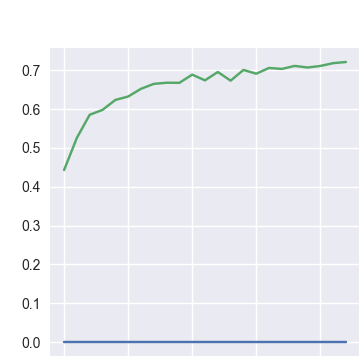

Epoch 1/1
37500/37500 [==============================] - 16s 425us/step - loss: 2.1686 - categorical_accuracy: 0.2926
Epoch 1/1
  3/750 [..............................] - ETA: 35s - loss: 1.8313 - categorical_accuracy: 0.4000

C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input52017") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


750/750 [==============================] - 32s 42ms/step - loss: 1.5943 - categorical_accuracy: 0.4436
1
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.3751 - categorical_accuracy: 0.5154
2
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.2465 - categorical_accuracy: 0.5583
3
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.1510 - categorical_accuracy: 0.5914
4
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.0760 - categorical_accuracy: 0.6190
5
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.0043 - categorical_accuracy: 0.6432
6
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 0.9662 - categorical_accuracy: 0.6599
7
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 0.9202 - categorical_accuracy: 0.6723
8
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 0.8844 - catego

KeyboardInterrupt: 

In [2]:
import numpy as np
NumTests = 100
from IPython.display import clear_output

Num_Epochs = 50

TestError_Record = np.zeros([2,NumTests])
Val_Acc_Record = np.zeros([Num_Epochs,2,NumTests])

for i in range(NumTests):
    clear_output()
    print('Run:')
    print(i)
    TestError_Record[:,i],Val_Acc_Record[:,:,i] = CIFAR_Dynamic_Exp(2,Num_Epochs)
    np.save('CIFAR_Dynamic_Perf_BALD_Hard_PropTask',TestError_Record)
    np.save('CIFAR_Dynamic_ValAcc_BALD_Hard_PropTask',Val_Acc_Record)

In [9]:
import numpy as np

NumPreds = 10

TestInputs = np.random.rand(1000,100)
TestTargets = np.random.rand(1000,10)

Pred = np.zeros([TestInputs.shape[0],TestTargets.shape[1],NumPreds])
for i in range(NumPreds):
    InitPred = np.random.rand(TestInputs.shape[0],TestTargets.shape[1])
    InitPred = np.exp(InitPred)
    InitPred /= np.sum(InitPred,axis=1,keepdims=True)
    
    Pred[:,:,i] = InitPred
    

In [10]:
MeanPred = Pred.mean(axis=2)

In [14]:
MeanPred.argmax(axis=1)

array([2, 7, 4, 1, 9, 7, 0, 3, 4, 5, 6, 4, 7, 1, 8, 6, 0, 4, 7, 3, 0, 7,
       2, 5, 4, 2, 6, 8, 1, 8, 6, 1, 8, 5, 7, 9, 1, 3, 8, 5, 4, 7, 7, 7,
       1, 4, 9, 5, 2, 9, 1, 6, 4, 1, 8, 7, 1, 8, 0, 2, 3, 9, 8, 7, 2, 6,
       0, 9, 4, 1, 4, 9, 3, 5, 4, 2, 9, 1, 8, 9, 8, 6, 5, 8, 0, 4, 9, 7,
       6, 5, 3, 9, 5, 1, 8, 5, 5, 2, 0, 5, 2, 5, 1, 6, 7, 4, 7, 0, 7, 5,
       2, 6, 7, 3, 4, 8, 5, 0, 9, 3, 5, 3, 4, 3, 2, 3, 9, 2, 3, 4, 7, 0,
       9, 0, 5, 6, 7, 6, 7, 6, 2, 5, 6, 8, 8, 6, 6, 9, 7, 1, 0, 4, 1, 4,
       4, 9, 8, 0, 8, 3, 6, 5, 6, 7, 2, 5, 1, 1, 2, 3, 1, 2, 1, 6, 1, 4,
       3, 8, 1, 2, 1, 2, 4, 4, 3, 7, 9, 9, 4, 7, 0, 2, 0, 0, 0, 7, 4, 2,
       3, 5, 9, 2, 4, 5, 4, 9, 4, 6, 1, 2, 5, 9, 3, 2, 8, 0, 7, 8, 2, 0,
       1, 0, 4, 4, 6, 1, 4, 5, 1, 7, 8, 7, 4, 4, 2, 9, 6, 7, 7, 9, 1, 4,
       2, 0, 3, 3, 9, 1, 1, 7, 6, 3, 7, 0, 4, 6, 1, 8, 9, 7, 2, 6, 4, 7,
       4, 5, 6, 2, 7, 2, 6, 2, 0, 4, 0, 3, 1, 3, 1, 4, 7, 3, 2, 7, 0, 1,
       4, 8, 7, 6, 0, 1, 6, 9, 1, 9, 9, 0, 1, 4, 4,

Using CNTK backend


GPU[0] Tesla K40c


C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1800)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 100)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\core.py:82: RuntimeWarning: data is not C contiguous; rearrange your data/computa

25


C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1800)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\core.py:672: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 100)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


<IPython.core.display.Javascript object>


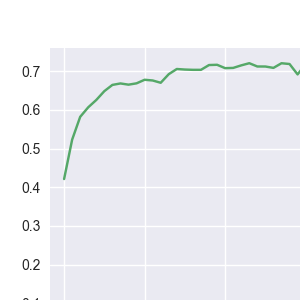

Epoch 1/1
37500/37500 [==============================] - 16s 428us/step - loss: 2.1451 - categorical_accuracy: 0.2931
Epoch 1/1
  3/750 [..............................] - ETA: 33s - loss: 1.8924 - categorical_accuracy: 0.3533

C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input1323") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


750/750 [==============================] - 32s 42ms/step - loss: 1.6235 - categorical_accuracy: 0.4264
1
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.3778 - categorical_accuracy: 0.5108
2
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.2428 - categorical_accuracy: 0.5589
3
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.1393 - categorical_accuracy: 0.5929
4
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.0630 - categorical_accuracy: 0.6230
5
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 1.0070 - categorical_accuracy: 0.6409
6
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 0.9507 - categorical_accuracy: 0.6627
7
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 0.8960 - categorical_accuracy: 0.6808
8
Epoch 1/1
750/750 [==============================] - 32s 42ms/step - loss: 0.8558 - catego

KeyboardInterrupt: 

In [1]:
%matplotlib notebook
import cntk
cntk.device.try_set_default_device(cntk.device.gpu(0))
import os
os.environ['KERAS_BACKEND'] = 'cntk'
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D, MaxPool2D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz
import seaborn as sns

from keras.layers.core import Lambda
from keras import backend as K    

print(K.cntk_backend.dev.use_default_device())

def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(label_list):
    NumLabels = len(label_list)
    MaxLabel = max(label_list)
    one_hot_labels = np.zeros([NumLabels,MaxLabel+1],dtype=int)
    for i in range(NumLabels):
        one_hot_labels[i,label_list[i]-1] = 1

    return one_hot_labels

def one_hot_reverse(one_hot_labels):
    labels = []
    for i in range(one_hot_labels.shape[0]):
        Sample = one_hot_labels[i,:]
        labels.append(Sample.argmax())

    return np.asarray(labels)

InitStr = 'cifar-10-python\cifar-10-batches-py\data_batch_'
File = InitStr + np.str(1)
Batch = unpickle(File)
FullInputs = Batch[b'data']
FullTargets = one_hot(Batch[b'labels'])


for i in  range(4):
    File = InitStr + np.str(i+2)
    Batch = unpickle(File)
    FullInputs = np.append(FullInputs,Batch[b'data'],axis=0)
    FullTargets = np.append(FullTargets,one_hot(Batch[b'labels']),axis=0)

Conv = 1
if Conv == 1:
    FullInputs = np.reshape(FullInputs,[FullInputs.shape[0],3,32,32]).transpose(0,2,3,1)

FullInputs = FullInputs.copy(order='C')

Validation_Cutoff = 0.75

Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])
if Conv == 1:
    ValInputs = FullInputs[Validation_Cutoff:,:,:,:]
else:
    ValInputs = FullInputs[Validation_Cutoff:,:]
ValTargets = FullTargets[Validation_Cutoff:,:]

if Conv == 1:
    TrainInputs = FullInputs[0:Validation_Cutoff,:,:,:]
else:
    TrainInputs = FullInputs[0:Validation_Cutoff,:]

TrainTargets = FullTargets[0:Validation_Cutoff,:]


data_dim = TrainInputs.shape[1]
if Conv == 1:
    data_dim2 = TrainInputs.shape[2]
    NumChannels = 3

NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0

def Gen_Conv_Model(reg_coeff):
    model = Sequential()
    model.add(Conv2D(50,(3,3),activation='relu',input_shape =(data_dim,data_dim2,NumChannels),data_format="channels_last"))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Conv2D(50,(3,3),activation='relu',data_format="channels_last"))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Lambda(lambda x: K.dropout(x, level=0.25)))
    model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
    model.add(Lambda(lambda x: K.dropout(x, level=0.25)))
#     model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

    return model

def Gen_FF_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adagrad(lr=0.00001,decay=0.95)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    return model

if Conv == 1:
    Uni_model = Gen_Conv_Model(reg_coeff)
else:
    Uni_model = Gen_FF_Model(reg_coeff)

Init_Weights = Uni_model.get_weights()

def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 30
    MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])

    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy

    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def acquisition_function_BALD_test(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 30
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = model.predict(samples)

    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy

    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob


def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        if NumTasks > 1:
            Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
            TaskInd = Sampling_Probability >= Cutoff
            DropInd = Sampling_Probability <  Cutoff
            Sampling_Probability[DropInd] = 0
            Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)

def Biased_Batch_Uni(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        if NumTasks > 1:
            Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
            TaskInd = Sampling_Probability >= Cutoff
            DropInd = Sampling_Probability <  Cutoff
            Sampling_Probability[TaskInd] = 1
            Sampling_Probability[DropInd] = 0
            Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


count = 0 
Num_Epochs = 50
Num_BurnIn = 1
Batch_Size = 100

NumTasks = 2
try:
    SwitchPoint = np.int(Num_Epochs/NumTasks)
    print(SwitchPoint)
except:
    SwitchPoint = 1
Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,2])
Val_Acc = np.zeros([Num_Epochs,2])

#     for i in range(Num_Epochs):
#         print(i)
#         Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
#         Predicted_Classes = Uni_model.predict_classes(ValInputs)
#         Val_Labels = one_hot_reverse(ValTargets)
#         Diff = Predicted_Classes - Val_Labels
#         Correct = Diff[Diff ==0 ]
#         Val_Acc[i,0] = Correct.shape[0]/Val_Labels.shape[0]

TestStr = 'cifar-10-python\cifar-10-batches-py\test_batch'

TestInputs = Batch[b'data']
TestTargets = one_hot(Batch[b'labels'])

if Conv == 1:
    TestInputs = np.reshape(TestInputs,[TestInputs.shape[0],3,32,32]).transpose(0,2,3,1)

Predicted_Classes = Uni_model.predict_classes(TestInputs)
Test_Labels = one_hot_reverse(TestTargets)
Diff = Predicted_Classes - Test_Labels
Correct = Diff[Diff ==0]
Uni_TestError = Correct.shape[0]/Test_Labels.shape[0]

D2T_Easy_Model = Gen_Conv_Model(reg_coeff)
D2T_Easy_Model.set_weights(Init_Weights)
del Uni_model

fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
        D2T_Easy_Model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
        Predicted_Classes = D2T_Easy_Model.predict_classes(ValInputs)
        Val_Labels = one_hot_reverse(ValTargets)
        Diff = Predicted_Classes - Val_Labels
        Correct = Diff[Diff ==0 ]
        Val_Acc[count,1] = Correct.shape[0]/Val_Labels.shape[0]
    else:

        PropTaskModel_Probability = acquisition_function_BALD_test(D2T_Easy_Model,TrainInputs,Num_Targets,1,10)
        PropTaskModel_Probability/= PropTaskModel_Probability.sum().astype(float)

        Phase = np.int((count-Num_BurnIn)/SwitchPoint)+1

        PhaseScale = np.int(NumTasks/Phase)

        D2T_Easy_Model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,PropTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                   steps_per_epoch=np.int(PhaseScale*(NumSamples/Batch_Size)),verbose=1)


        Predicted_Classes = D2T_Easy_Model.predict_classes(ValInputs)
        Val_Labels = one_hot_reverse(ValTargets)
        Diff = Predicted_Classes - Val_Labels
        Correct = Diff[Diff ==0 ]
        Val_Acc[count,1] = Correct.shape[0]/Val_Labels.shape[0]

        print(EpochLoop)

    count += 1

    ax.clear()
    ax.plot(Val_Acc[0:count,:],label='UniTaskEasy')
    fig.canvas.draw()

def MC_Class_Pred(model,Inputs,Targets,NumPreds):
    Pred = np.zeros([Inputs.shape[0],Targets.shape[1],NumPreds])
    for i in range(NumPreds):
        InitPred = model.predict(Inputs)
        Pred[:,:,i] = InitPred

    MeanPred = Pred.mean(axis=2)
    Predicted_Classes = MeanPred.argmax(axis=1)
    return Predicted_Classes

#     Predicted_Classes = D2T_Easy_Model.predict_classes(TestInputs)
Predicted_Classes = MC_Class_Pred(D2T_Easy_Model,TestInputs,TestTargets,10)
Test_Labels = one_hot_reverse(TestTargets)
Diff = Predicted_Classes - Test_Labels
Correct = Diff[Diff ==0 ]
D2T_Easy_TestError = Correct.shape[0]/Test_Labels.shape[0]

Errors = np.array([Uni_TestError,D2T_Easy_TestError])


In [56]:
def acquisition_function_BALD_test(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 30
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = model.predict(samples)
        print(i)

    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy

    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob




PropTaskModel_Probability = acquisition_function_dist_to_threshold(D2T_Easy_Model,TrainInputs,Num_Targets,1,10)
# PropTaskModel_Probability/= PropTaskModel_Probability.sum().astype(float)

In [57]:
PropTaskModel_Probability_Sort = np.argsort(PropTaskModel_Probability)
TopTenUncertain = PropTaskModel_Probability_Sort[-1-3:]
TopTenMostCertain = PropTaskModel_Probability_Sort[0:4]

In [58]:
PropTaskModel_Probability_Sort[-1]

11968

In [59]:
PropTaskModel_Probability.argmax()

11968

<IPython.core.display.Javascript object>


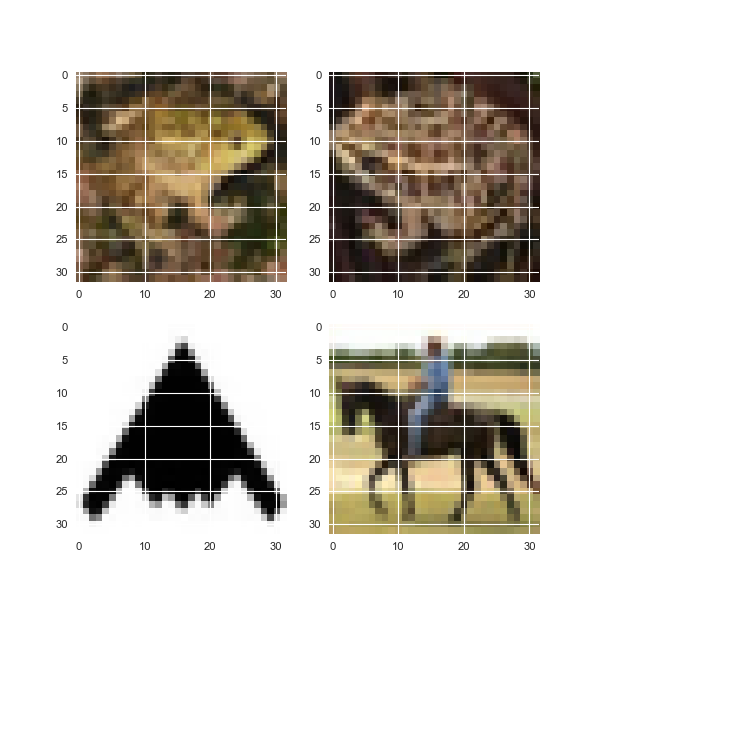

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 7.5))
randind = np.random.randint(0,FullInputs.shape[0],size = 8)
axes[0,0].imshow(TrainInputs[TopTenUncertain[3],:,:,:])
axes[0,1].imshow(TrainInputs[TopTenUncertain[2],:,:,:])
axes[1,0].imshow(TrainInputs[TopTenUncertain[1],:,:,:])
axes[1,1].imshow(TrainInputs[TopTenUncertain[0],:,:,:])
plt.show()

In [63]:
fig.savefig('CIFAR_Uncertain_Samples_D2T.png')

<IPython.core.display.Javascript object>


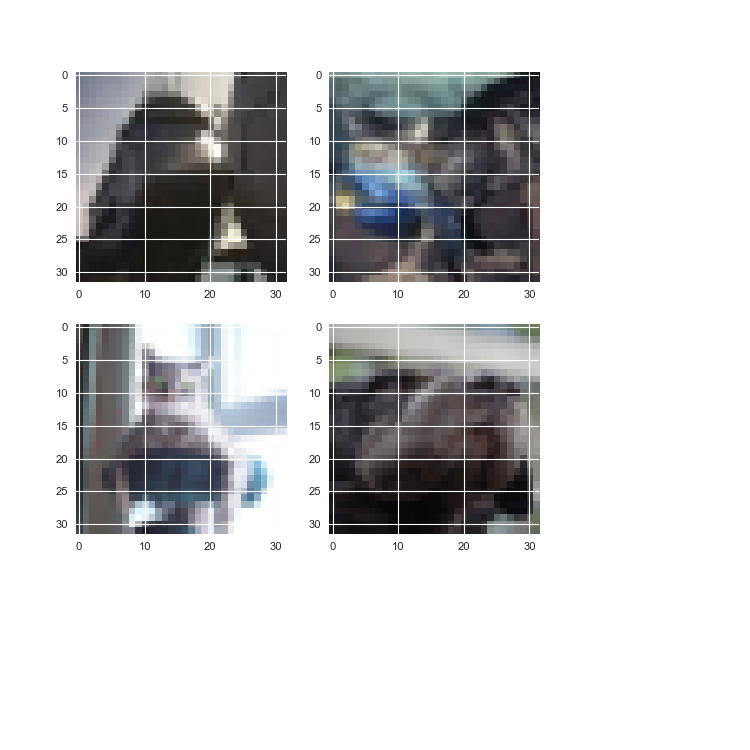

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 7.5))
randind = np.random.randint(0,FullInputs.shape[0],size = 8)
axes[0,0].imshow(TrainInputs[TopTenMostCertain[0],:,:,:])
axes[0,1].imshow(TrainInputs[TopTenMostCertain[1],:,:,:])
axes[1,0].imshow(TrainInputs[TopTenMostCertain[2],:,:,:])
axes[1,1].imshow(TrainInputs[TopTenMostCertain[3],:,:,:])
plt.show()

In [67]:
fig.savefig('CIFAR_certain_Samples_D2T}.png')